# Development of a wind force model
So far the vessel manoeuvring models (VMM:s) have only considered the hydrodynamic forces. This notebook explores how the wind force can be incorporated into the models in a convenient way.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 10000)
import numpy as np
import yaml

from vessel_manoeuvring_models.visualization.plot import track_plot, plot
from phd.visualization.plot_ship import track_plots
from vessel_manoeuvring_models.extended_kalman_vmm import ExtendedKalman, SystemMatrixes
from vmm_abkowitz_diminished import vmm as vmm
from wPCC_pipeline.pipelines.brix.nodes import initial_parameters, extract_added_masses
from wPCC_pipeline.pipelines.preprocess.nodes import load, add_thrust
from wPCC_pipeline.pipelines.filter_data_extended_kalman.nodes import guess_covariance_matrixes, initial_state, extended_kalman_filter, extended_kalman_smoother
from wPCC_pipeline.pipelines.motion_regression.nodes import predict_force, fit_motions, create_model_from_motion_regression
from wPCC_pipeline.pipelines.prediction.nodes import simulate_euler
from phd.pipelines.load_7m.nodes import fix_interpolated_angle
from sklearn.metrics import mean_squared_error
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator, get_coefficients
import sympy as sp
from functools import reduce
from operator import add
from vessel_manoeuvring_models.symbols import *
from IPython.display import display
from vessel_manoeuvring_models.prime_system import df_prime
from vessel_manoeuvring_models.substitute_dynamic_symbols import run, lambdify
from vessel_manoeuvring_models.models.vmm import VMM, Simulator, ModelSimulator
from vessel_manoeuvring_models.parameters import df_parameters
from phd.helpers import mean
from vessel_manoeuvring_models.angles import mean_angle
from vessel_manoeuvring_models.angles import smallest_signed_angle
import inspect

import matplotlib.pyplot as plt
plt.style.use('bmh')

In [3]:
import anyconfig
globals_path = "../conf/base/globals.yml"
global_variables = anyconfig.load(globals_path)
ships = global_variables["ships"]

In [4]:
%reload_kedro
ship='7m'

time_series = catalog.load(f"{ship}.tests")
ship_data = catalog.load(f"{ship}.ship_data")
exclude_parameters = catalog.load(f"params:{ship}.exclude_parameters")
time_series_meta_data = catalog.load(f"{ship}.test_meta_data")
time_series_meta_data.index = time_series_meta_data.index.astype(str)
wind_data = catalog.load(f"{ship}.wind_data")
model_loaders = catalog.load(f"{ship}.models")

[05/22/23 16:11:04] INFO     Resolved project path as: /home/maa/dev/PHD.                           ]8;id=130954;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=638602;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#134\134]8;;\
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/22/23 16:11:04] INFO     Kedro project phd                                                      ]8;id=422358;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=660523;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#103\103]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=101489;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=146103;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#104\104]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=982345;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=35533;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/ipython/__init__.py#110\110]8;;\

                    INFO     Loading data from '7m.tests' (PartitionedDataSet)...               ]8;id=810023;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=14512;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.ship_data' (YAMLDataSet)...                  ]8;id=584136;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=604018;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from 'params:7m.exclude_parameters'                   ]8;id=934511;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=498399;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\
                             (MemoryDataSet)...                                                                    

                    INFO     Loading data from '7m.test_meta_data' (CSVDataSet)...              ]8;id=553004;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=173824;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.wind_data' (CSVDataSet)...                   ]8;id=875666;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=547931;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

                    INFO     Loading data from '7m.models' (PartitionedDataSet)...              ]8;id=391991;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=90621;file:///home/maa/anaconda3/envs/phd/lib/python3.10/site-packages/kedro/io/data_catalog.py#343\343]8;;\

## Apparent wind

In [5]:
from sympy.vector import CoordSys3D, express
tws, twa, cog = sp.symbols('tws twa cog')
N = CoordSys3D('N')
S = N.orient_new_axis('S', psi, N.k)

W = -tws*sp.cos(twa)*N.i + -tws*sp.sin(twa)*N.j
V = U*sp.cos(cog)*N.i + U*sp.sin(cog)*N.j
H = -V
A = W + H

In [6]:
W

(-tws*cos(twa))*N.i + (-tws*sin(twa))*N.j

In [7]:
W.dot(N.i)

-tws*cos(twa)

In [8]:
W.dot(N.j)

-tws*sin(twa)

In [9]:
express(V,S)

(U*sin(\Psi)*sin(cog) + U*cos(\Psi)*cos(cog))*S.i + (-U*sin(\Psi)*cos(cog) + U*sin(cog)*cos(\Psi))*S.j

In [10]:
express(W,S)

(-tws*sin(\Psi)*sin(twa) - tws*cos(\Psi)*cos(twa))*S.i + (tws*sin(\Psi)*cos(twa) - tws*sin(twa)*cos(\Psi))*S.j

In [11]:
S.rotation_matrix(N)

Matrix([
[ cos(\Psi), sin(\Psi), 0],
[-sin(\Psi), cos(\Psi), 0],
[         0,         0, 1]])

In [12]:
express(W,N)

(-tws*cos(twa))*N.i + (-tws*sin(twa))*N.j

In [13]:
A_s = express(A,S)

In [14]:
eq_aws = sp.Eq(aws,sp.simplify(A_s.magnitude()))
eq_aws

Eq(aws, sqrt(U**2 + 2*U*tws*cos(cog - twa) + tws**2))

In [15]:
#eq_awa = sp.Eq(awa, sp.pi + sp.simplify(sp.acos(A_s.dot(S.i)/A_s.magnitude())))
#eq_awa

In [16]:
eq_awa = sp.Eq(awa, sp.simplify(sp.atan2(A_s.dot(S.j),A_s.dot(S.i)) + sp.pi))
eq_awa

Eq(awa, atan2(U*sin(\Psi - cog) + tws*sin(\Psi - twa), -U*cos(\Psi - cog) - tws*cos(\Psi - twa)) + pi)

In [17]:
#eq_awa = sp.Eq(awa, sp.simplify(sp.acos(A_s.dot(S.i)/eq_aws.rhs) + sp.pi))
#eq_awa

In [18]:
lambda_aws = lambdify(eq_aws.rhs)
lambda_awa = lambdify(eq_awa.rhs.subs(psi,'psi'))

In [19]:
print(inspect.getsource(lambda_aws))

def _lambdifygenerated(U, cog, twa, tws):
    return sqrt(U**2 + 2*U*tws*cos(cog - twa) + tws**2)



In [20]:
print(inspect.getsource(lambda_awa))

def _lambdifygenerated(U, cog, psi, twa, tws):
    return arctan2(-U*sin(cog - psi) + tws*sin(psi - twa), -U*cos(cog - psi) - tws*cos(psi - twa)) + pi



In [21]:
lambda_aws(U=10,cog=0, twa=np.deg2rad(90), tws=10)

14.142135623730951

In [22]:
np.rad2deg(smallest_signed_angle(lambda_awa(U=10,cog=0, psi=0, twa=np.deg2rad(0), tws=10)))

0.0

In [23]:
np.rad2deg(smallest_signed_angle(lambda_awa(U=10,cog=0, psi=0, twa=np.deg2rad(90), tws=10)))

45.0

In [24]:
np.rad2deg(lambda_awa(U=10,cog=0, psi=0, twa=np.deg2rad(90), tws=10))

45.0

In [25]:
A = -aws*sp.cos(awa)*S.i - aws*sp.sin(awa)*S.j
V = U*sp.cos(cog)*N.i + U*sp.sin(cog)*N.j
H = -V

#A = W + H
W = A - H

A_n = sp.simplify(express(W,S).doit())

In [26]:
eq_tws = sp.Eq(tws,sp.simplify(A_n.magnitude()))
eq_tws

Eq(tws, sqrt(U**2 - 2*U*aws*cos(\Psi + awa - cog) + aws**2))

In [27]:
#eq_twa = sp.Eq(twa, sp.simplify(sp.acos(A_n.dot(N.i)/A_n.magnitude()) + sp.pi))
#eq_twa

In [28]:
eq_twa = sp.Eq(twa, sp.simplify(sp.atan2(A_n.dot(N.j),A_n.dot(N.i)) + sp.pi))
eq_twa

Eq(twa, atan2(U*sin(cog) - aws*sin(\Psi + awa), U*cos(cog) - aws*cos(\Psi + awa)) + pi)

In [29]:
#eq_twa = sp.Eq(twa, sp.simplify(sp.acos(A_n.dot(N.i)/A_n.magnitude())) + sp.pi)
#eq_twa

In [30]:
lambda_tws = lambdify(eq_tws.rhs.subs(psi,'psi'))
lambda_twa = lambdify(eq_twa.rhs.subs(psi,'psi'))

In [31]:
print(inspect.getsource(lambda_tws))

def _lambdifygenerated(U, awa, aws, cog, psi):
    return sqrt(U**2 - 2*U*aws*cos(awa - cog + psi) + aws**2)



In [32]:
print(inspect.getsource(lambda_twa))

def _lambdifygenerated(U, awa, aws, cog, psi):
    return arctan2(U*sin(cog) - aws*sin(awa + psi), U*cos(cog) - aws*cos(awa + psi)) + pi



In [33]:
U_ = 10
twa_ = np.deg2rad(120)
tws_ = 10
aws_ = lambda_aws(U=U_,cog=0, twa=twa_, tws=tws_)
awa_ = lambda_awa(U=U_,cog=0, psi=0, twa=twa_, tws=tws_)

lambda_tws(U=U_, awa=awa_, aws=aws_, cog=0, psi=0)

9.999999999999998

In [34]:
np.rad2deg(smallest_signed_angle(awa_))

59.999999999999986

In [35]:
np.rad2deg(smallest_signed_angle(lambda_twa(U=U_, awa=awa_, aws=aws_, cog=0, psi=0)))

119.99999999999997

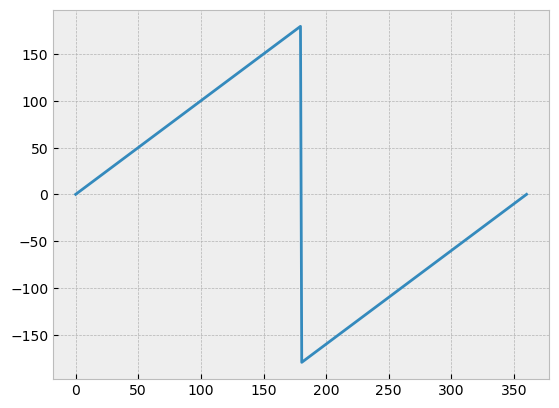

In [36]:
U_ = 0
twa_ = np.deg2rad(np.linspace(0,360,360))
tws_ = 10

awa_ = smallest_signed_angle(lambda_awa(U=U_,cog=0, psi=np.deg2rad(0), twa=twa_, tws=tws_))

fig,ax=plt.subplots()
ax.plot(np.rad2deg(twa_), np.rad2deg(awa_))

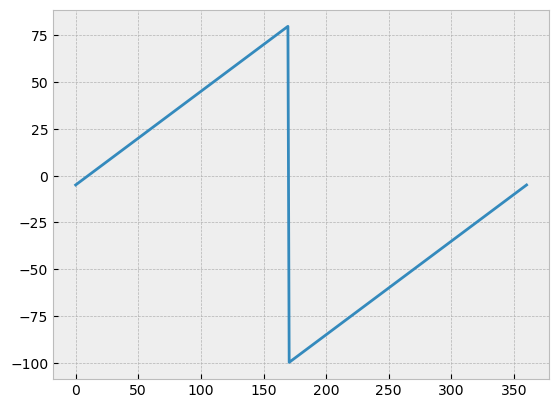

In [37]:
U_ = 10
twa_ = np.deg2rad(np.linspace(0,360,360))
tws_ = 10

awa_ = smallest_signed_angle(lambda_awa(U=U_,cog=np.deg2rad(-10), psi=np.deg2rad(0), twa=twa_, tws=tws_))

fig,ax=plt.subplots()
ax.plot(np.rad2deg(twa_), np.rad2deg(awa_))

In [38]:
N = CoordSys3D('N')
A = sp.cos(psi)*N.i + sp.sin(psi)*N.j

lambda_ = lambdify(sp.simplify(sp.atan2(A.dot(N.j),A.dot(N.i))).subs(psi,'psi'))

In [39]:
np.rad2deg(lambda_(np.deg2rad(120)))

119.99999999999999

## Load some lake data

In [40]:
data_raw = time_series['4']()

psi_ = data_raw['psi']
#data_raw['twaBowRAW']=np.unwrap(data_raw['twaBowRAW'] + psi_)  # Ship fixed -> Earth fixed
#data_raw['twaBow']=np.unwrap(data_raw['twaBow'] + psi_)  # Ship fixed -> Earth fixed


#data_raw = time_series['1']()

#data_raw = fix_interpolated_angle(data=data_raw, key="awaBowRAW")
#data_raw = fix_interpolated_angle(data=data_raw, key="awaSternRAW")
#data_raw = fix_interpolated_angle(data=data_raw, key="awaBow")
#data_raw = fix_interpolated_angle(data=data_raw, key="awaStern")
#data_raw = fix_interpolated_angle(data=data_raw, key="twaBowRAW")
#data_raw = fix_interpolated_angle(data=data_raw, key="twaBow")
#data_raw = fix_interpolated_angle(data=data_raw, key="twa")
#data_raw = fix_interpolated_angle(data=data_raw, key="awa")

In [41]:
data = load(raw_data=data_raw)
data.drop(columns=['mission','date'], inplace=True)
data['delta_deg'] = np.rad2deg(data['delta'])
data['psi_deg'] = np.rad2deg(data['psi'])
data_all = data.copy()
#delta = data_all['delta'] = data_all['delta'] - (data_all['delta'].max() - (data_all['delta'].max() - data_all['delta'].min())/2)
#data['delta'] = delta
#data['delta']*=-1



#data['twa'] = data['twaBowRAW']
#data['awa'] = smallest_signed_angle(data['awaBowRAW'])
#data['aws'] = data['awsBowRAW']


In [42]:
data.head()

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,thrusterTarget,courseTarget,pitchAngle,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,awaBowRAW,awsBowRAW,twaBowRAW,twsBowRAW,awaSternRAW,awsSternRAW,twsSternRAW,delta,V,U,beta,u,v,psi,phi,r,u1d,v1d,r1d,y_GPS,x_GPS,x0,y0,aws,awa,tws,twa,global time,delta_deg,psi_deg
time(us),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,6.1214,0.163385,1.7796,3.4409,3.2506,59.293256,18.321301,0.0212,-2.8797,1.7941,-3.0216,3.5383,-2.9234,2.2584,-3.0280,4.0127,60.0,6.1087,0.0068,-0.0276,0.0007,0.0057,0.0414,-0.1681,-9.8297,-2.8449,1.9034,-3.0297,3.6423,-2.9671,2.6751,4.4382,-0.056734,1.7796,1.7796,6.284785,1.779598,-0.002847,0.161785,0.0212,0.005502,0.010425,-0.025860,-0.020016,176.314069,1560.669215,0.000000,0.000000,2.28925,2.90600,4.040719,-3.111728,3464.356878,-3.2506,9.269615
0.199930,6.1225,0.161585,1.7817,13.4409,3.4028,59.293259,18.321300,0.0149,-2.8771,1.8055,-3.0188,3.5494,-2.9256,2.2867,-3.0279,4.0416,60.0,6.1087,0.0073,-0.0276,0.0035,0.0038,0.0517,-0.2036,-9.7909,-2.8449,1.9351,-3.0099,3.6745,-2.9563,2.6434,4.4056,-0.059390,1.7817,1.7817,6.287685,1.781682,-0.008018,0.162885,0.0149,0.001500,-0.021018,0.083642,0.035005,176.258192,1561.044756,0.376566,-0.052968,2.28925,2.91140,4.040799,-3.108922,3464.556808,-3.4028,9.332641
0.399917,6.1228,0.171285,1.7775,13.4409,5.4571,59.293262,18.321299,0.0103,-2.8766,1.8093,-3.0176,3.5534,-2.9255,2.3067,-3.0269,4.0616,60.0,6.1087,0.0080,-0.0114,0.0033,0.0043,0.0788,-0.0270,-9.7854,-2.8641,1.8794,-2.9909,3.6236,-2.9304,2.5670,4.3234,-0.095244,1.7775,1.7775,6.278285,1.777479,0.008710,0.163185,0.0103,0.008501,0.012584,0.121129,-0.035008,176.207806,1561.406866,0.738955,-0.102560,2.22320,2.91475,3.972420,-3.104226,3464.756795,-5.4571,9.349829
0.599902,6.1245,0.186585,1.7803,13.4409,9.2897,59.293265,18.321299,0.0105,-2.8786,1.8041,-3.0184,3.5489,-2.9236,2.3185,-3.0253,4.0730,60.0,6.1087,0.0081,0.0155,-0.0027,0.0079,0.0202,-0.2320,-9.7727,-2.9014,1.7430,-3.0237,3.4965,-2.8993,2.4632,4.2122,-0.162136,1.7803,1.7803,6.264685,1.779995,0.032934,0.164885,0.0105,0.001500,0.015106,-0.005961,0.039984,176.164274,1561.756841,1.090506,-0.141594,2.10310,2.91165,3.859508,-3.101381,3464.956780,-9.2897,9.447232
0.799961,6.1248,0.186185,1.7833,13.4409,11.8712,59.293269,18.321298,0.0146,-2.8826,1.7960,-3.0207,3.5424,-2.9229,2.3261,-3.0251,4.0809,60.0,6.1087,0.0072,0.0268,-0.0060,0.0106,0.0358,-0.3286,-9.8280,-2.9276,1.7044,-3.0231,3.4682,-2.9124,2.4246,4.1824,-0.207192,1.7833,1.7833,6.265385,1.783017,0.031741,0.165185,0.0146,0.009499,-0.033094,-0.144474,0.045035,176.122989,1562.107834,1.441777,-0.182084,2.06450,2.89200,3.827949,-3.113079,3465.156839,-11.8712,9.464421


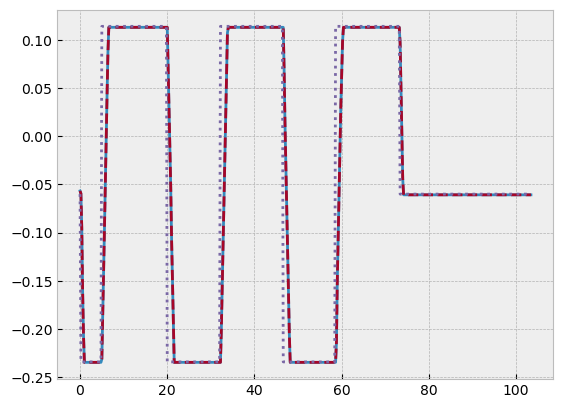

In [43]:
fig,ax=plt.subplots()
ax.plot(-np.deg2rad(data['rudderAngle']))
ax.plot(data['delta'],'--')
ax.plot(-np.deg2rad(data['rudderTarget']),':')


<Axes: xlabel='time(us)'>

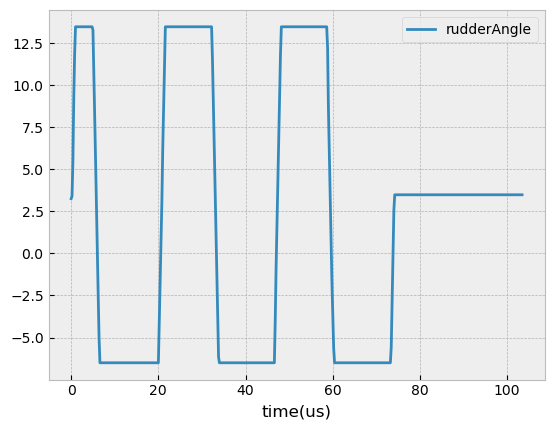

In [44]:
data.plot(y='rudderAngle')

<Axes: xlabel='time(us)'>

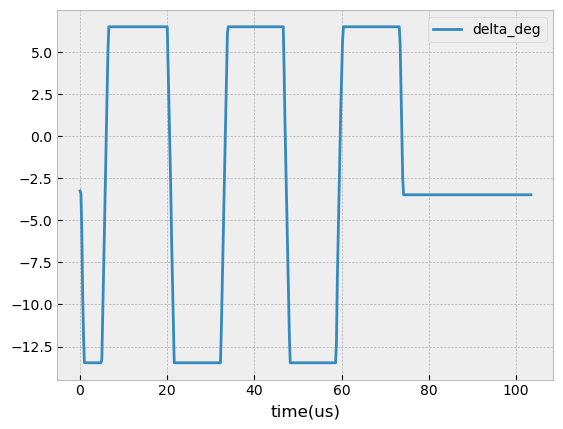

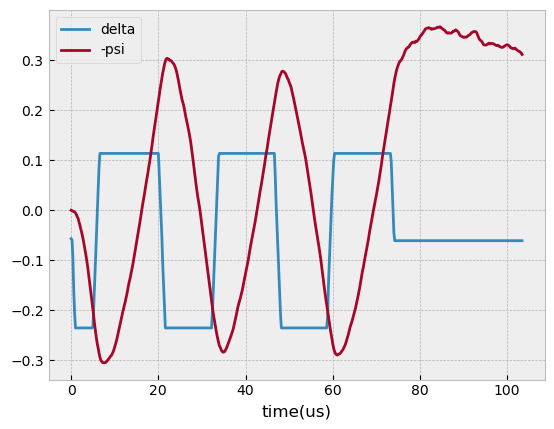

In [45]:
data.plot(y='delta_deg')

fig,ax=plt.subplots()
data['-psi'] = -(data['psi']-data.iloc[0]['psi'])
data.plot(y=['delta','-psi'], ax=ax)

In [46]:
data.head()

,yaw,cog,sog,rudderTarget,rudderAngle,latitude,longitude,heelAngle,awaBow,awsBow,twaBow,twsBow,awaStern,awsStern,twaStern,twsStern,thrusterTarget,courseTarget,pitchAngle,GyroX,GyroY,GyroZ,AccelX,AccelY,AccelZ,awaBowRAW,awsBowRAW,twaBowRAW,twsBowRAW,awaSternRAW,awsSternRAW,twsSternRAW,delta,V,U,beta,u,v,psi,phi,r,u1d,v1d,r1d,y_GPS,x_GPS,x0,y0,aws,awa,tws,twa,global time,delta_deg,psi_deg,-psi
time(us),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000000,6.1214,0.163385,1.7796,3.4409,3.2506,59.293256,18.321301,0.0212,-2.8797,1.7941,-3.0216,3.5383,-2.9234,2.2584,-3.0280,4.0127,60.0,6.1087,0.0068,-0.0276,0.0007,0.0057,0.0414,-0.1681,-9.8297,-2.8449,1.9034,-3.0297,3.6423,-2.9671,2.6751,4.4382,-0.056734,1.7796,1.7796,6.284785,1.779598,-0.002847,0.161785,0.0212,0.005502,0.010425,-0.025860,-0.020016,176.314069,1560.669215,0.000000,0.000000,2.28925,2.90600,4.040719,-3.111728,3464.356878,-3.2506,9.269615,-0.0000
0.199930,6.1225,0.161585,1.7817,13.4409,3.4028,59.293259,18.321300,0.0149,-2.8771,1.8055,-3.0188,3.5494,-2.9256,2.2867,-3.0279,4.0416,60.0,6.1087,0.0073,-0.0276,0.0035,0.0038,0.0517,-0.2036,-9.7909,-2.8449,1.9351,-3.0099,3.6745,-2.9563,2.6434,4.4056,-0.059390,1.7817,1.7817,6.287685,1.781682,-0.008018,0.162885,0.0149,0.001500,-0.021018,0.083642,0.035005,176.258192,1561.044756,0.376566,-0.052968,2.28925,2.91140,4.040799,-3.108922,3464.556808,-3.4028,9.332641,-0.0011
0.399917,6.1228,0.171285,1.7775,13.4409,5.4571,59.293262,18.321299,0.0103,-2.8766,1.8093,-3.0176,3.5534,-2.9255,2.3067,-3.0269,4.0616,60.0,6.1087,0.0080,-0.0114,0.0033,0.0043,0.0788,-0.0270,-9.7854,-2.8641,1.8794,-2.9909,3.6236,-2.9304,2.5670,4.3234,-0.095244,1.7775,1.7775,6.278285,1.777479,0.008710,0.163185,0.0103,0.008501,0.012584,0.121129,-0.035008,176.207806,1561.406866,0.738955,-0.102560,2.22320,2.91475,3.972420,-3.104226,3464.756795,-5.4571,9.349829,-0.0014
0.599902,6.1245,0.186585,1.7803,13.4409,9.2897,59.293265,18.321299,0.0105,-2.8786,1.8041,-3.0184,3.5489,-2.9236,2.3185,-3.0253,4.0730,60.0,6.1087,0.0081,0.0155,-0.0027,0.0079,0.0202,-0.2320,-9.7727,-2.9014,1.7430,-3.0237,3.4965,-2.8993,2.4632,4.2122,-0.162136,1.7803,1.7803,6.264685,1.779995,0.032934,0.164885,0.0105,0.001500,0.015106,-0.005961,0.039984,176.164274,1561.756841,1.090506,-0.141594,2.10310,2.91165,3.859508,-3.101381,3464.956780,-9.2897,9.447232,-0.0031
0.799961,6.1248,0.186185,1.7833,13.4409,11.8712,59.293269,18.321298,0.0146,-2.8826,1.7960,-3.0207,3.5424,-2.9229,2.3261,-3.0251,4.0809,60.0,6.1087,0.0072,0.0268,-0.0060,0.0106,0.0358,-0.3286,-9.8280,-2.9276,1.7044,-3.0231,3.4682,-2.9124,2.4246,4.1824,-0.207192,1.7833,1.7833,6.265385,1.783017,0.031741,0.165185,0.0146,0.009499,-0.033094,-0.144474,0.045035,176.122989,1562.107834,1.441777,-0.182084,2.06450,2.89200,3.827949,-3.113079,3465.156839,-11.8712,9.464421,-0.0034


In [47]:
def apparent_wind_to_true(sog, aw, awa):
    return np.sqrt(aw ** 2 + sog ** 2 - 2 * aw * sog * np.cos(awa))


def apparent_wind_angle_to_true(sog, aw, awa):
    return np.arccos(
        (aw * np.cos(awa) - sog)
        / np.sqrt(aw ** 2 + sog ** 2 - 2 * aw * sog * np.cos(awa))
    )

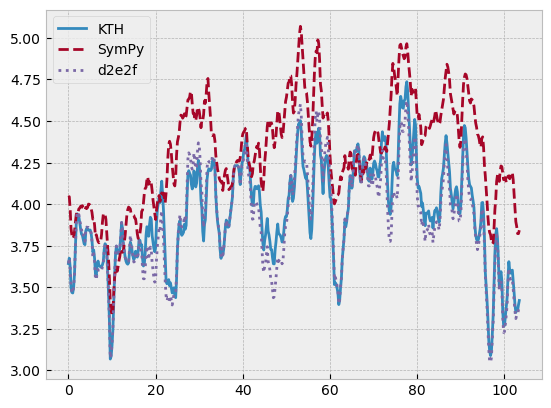

In [48]:
fig,ax=plt.subplots()
data['tws'] = run(lambda_tws, inputs=data)
ax.plot(data['twsBowRAW'], label='KTH')
ax.plot(data['tws'], '--', label='SymPy')
ax.plot(apparent_wind_to_true(sog=data['sog'], aw=data['awsBowRAW'], awa=data['awaBowRAW']),':',label='d2e2f')
ax.legend()

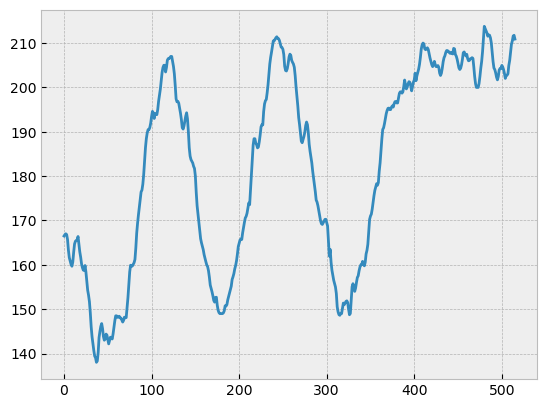

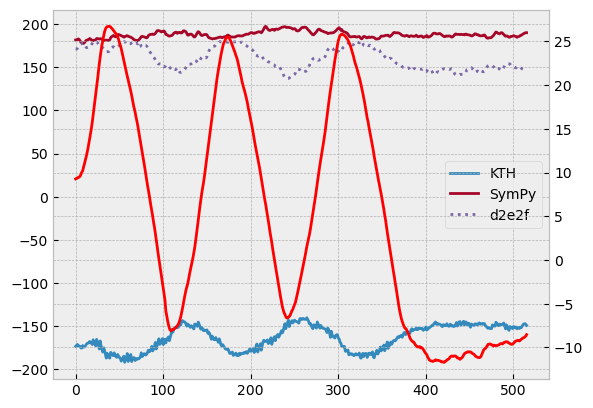

In [49]:
fig,ax=plt.subplots()
ax.plot(np.rad2deg(np.unwrap(data['awa'])))

fig,ax=plt.subplots()
data['twa_'] = np.unwrap(data['twaBowRAW'])
#data['twa_']-= (data.iloc[0]['twa_'] - smallest_signed_angle(data.iloc[0]['twa_']))
ax.plot(np.rad2deg(np.unwrap(data['twa_'])), label='KTH')
data['twa'] = run(lambda_twa, inputs=data)

#data['twa']-= np.pi # Hm....

ax.plot(np.rad2deg(np.unwrap(data['twa'])), label='SymPy')
ax.plot(np.rad2deg(apparent_wind_angle_to_true(sog=data['sog'], aw=data['awsBowRAW'], awa=data['awaBowRAW'])).values,':',label='d2e2f')
ax.legend()

ax2 = ax.twinx()
ax2.plot(np.rad2deg(np.unwrap(data['psi'])), 'r-')






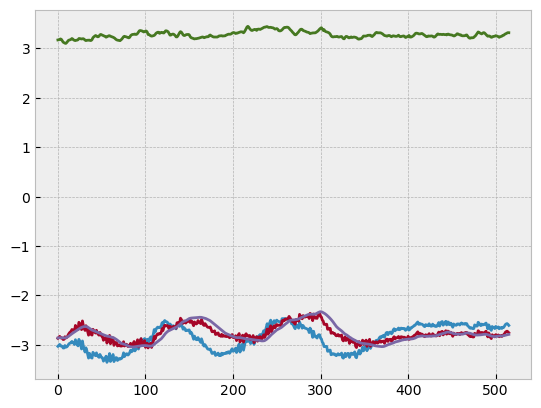

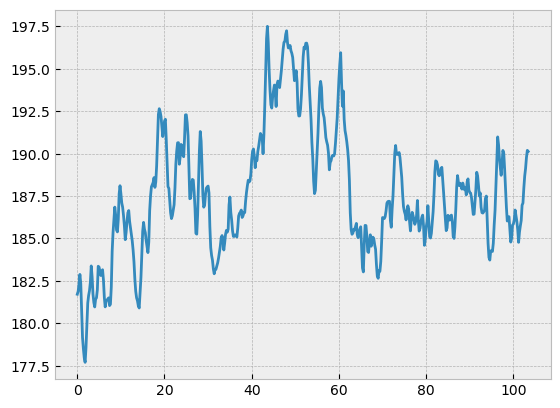

In [50]:
data['twa'] = run(lambda_twa, inputs=data)
#data['twa']=data['twa'] - np.pi  # Hm...

#data.plot(y=['twaBowRAW','twaBow','twa'])
fig,ax=plt.subplots()
ax.plot(np.unwrap(data['twaBowRAW']))
ax.plot(np.unwrap(data['twaBowRAW']+data['psi']))
ax.plot(np.unwrap(data['twaBow']+data['psi']))
ax.plot(data['twa'].values)

fig,ax=plt.subplots()
ax.plot(np.rad2deg(data['twa']))

<Axes: xlabel='time(us)'>

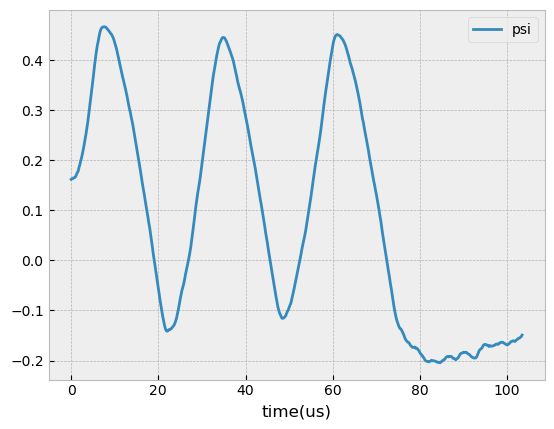

In [51]:
data.plot(y='psi')

In [52]:
np.rad2deg(mean_angle(data['twa']))

-172.30508842627927

## Coefficients

In [90]:
wind_data_HMD = pd.read_csv("HMD_PCTC.wind_data.csv", index_col=0)
wind_data_HMD.rename(columns={column:column.lower().replace(' ','') for column in wind_data_HMD.columns}, inplace=True)
wind_data_HMD.index=360-wind_data_HMD.index

In [91]:
wind_data_HMD.head()

,cx,cy,ck,cn
awa [deg],,,,
360,-0.596,0.002,0.007,-0.001
350,-0.618,0.172,0.205,0.024
340,-0.623,0.400,0.464,0.048
330,-0.546,0.669,0.770,0.064
320,-0.328,0.900,1.014,0.077


In [55]:
wind_data_HMD.columns

Index(['cx', 'cy', 'ck', 'cn'], dtype='object')

In [56]:
wind_data

,Lpp [m],Sx [m2],Sy [m2],TWS [m/s],Vs [kts],AWS [m/s],Fx [N],Fy [N],Mx [Nm],Mz [Nm],Ml [Nm],Mn [Nm]
AWA [°],,,,,,,,,,,,
0,206,1008.34776,5433.5156,10,10,15.144000,-23669,395,-8761,13048,-5403.5,-28427
35,206,1008.34776,5433.5156,10,10,13.768543,-15176,275370,-6849529,42161608,-4508884.0,13247758
60,206,1008.34776,5433.5156,10,10,11.524900,9260,277602,-7386496,36149065,-5026879.0,7000855
90,206,1008.34776,5433.5156,10,10,8.575500,-11126,132302,-4020585,13323275,-2896018.0,-568435
120,206,1008.34776,5433.5156,10,10,6.380900,1644,77922,-2554601,4510682,-1892264.0,-3671128
145,206,1008.34776,5433.5156,10,10,5.341107,25,6645,-547,138922,55935.5,-558803
180,206,1008.34776,5433.5156,10,10,4.856000,7221,555,-11437,80869,-6719.5,22594


In [57]:
wind_data.iloc[0]['Sx [m2]']/(ship_data['scale_factor']**2)

1.1203864

In [58]:
wind_data.iloc[0]['Sy [m2]']/(ship_data['scale_factor']**2)

6.037239555555555

In [59]:
rho_air = 1.225
lpp = wind_data['Lpp [m]']
sx = wind_data['Sx [m2]']
sy = wind_data['Sy [m2]']
aws = wind_data['AWS [m/s]']
fx = wind_data['Fx [N]']
fy = wind_data['Fy [N]']
mz = wind_data['Mn [Nm]']

In [60]:
wind_data['awa'] = np.deg2rad(wind_data.index)
wind_data_HMD['awa'] = np.deg2rad(wind_data_HMD.index)

wind_data['awa'] = np.mod(wind_data['awa'] + np.pi, 2 * np.pi) - np.pi
wind_data_HMD['awa'] = np.mod(wind_data_HMD['awa'] + np.pi, 2 * np.pi) - np.pi
wind_data.sort_values(by='awa', inplace=True)
wind_data_HMD.sort_values(by='awa', inplace=True)


In [61]:
wind_data['cx'] = fx/(1/2*rho_air*sx*aws**2)
wind_data['cy'] = fy/(1/2*rho_air*sy*aws**2)
wind_data['cn'] = mz/(1/2*rho_air*sy*aws**2*lpp)

In [62]:
data_ = wind_data_HMD.copy()

x = data_['awa'].abs()
y = data_['cx']
coeffs_cx = np.polyfit(x=x, y=y, deg=6)


x = data_['awa'].abs()
y = data_['cy'].abs()
coeffs_cy = np.polyfit(x=x, y=y, deg=3)

x = data_['awa'].abs()
y = data_['cn']
mask = data_['awa'] < 0
y.loc[mask]*=-1
coeffs_cn = np.polyfit(x=x, y=y, deg=3)

In [63]:
coeffs_cx

array([  0.17026096,  -1.83918845,   7.3656144 , -13.39004246,
        10.81894988,  -2.74459708,  -0.53037727])

In [64]:
def get_X(x, deg=1, const=True):
    
    if const:
        stop = -1
    else:
        stop = 0
        
    X = np.array(np.matrix([x**i for i in range(deg,stop,-1)]))
    return X

def get_X_abs(x, deg=1, const=True):
    
    if const:
        stop = -1
    else:
        stop = 0
        
    X = np.array(np.matrix([np.abs(x**i) for i in range(deg,stop,-1)]))
    return X

def get_X_sign(x, deg=1, const=True):
    
    if const:
        stop = -1
    else:
        stop = 0

    parts = [np.sign(x)*np.abs(x**i) for i in range(deg,stop,-1)]
        
    X = np.array(np.matrix(parts))
    return X
    

Text(0, 0.5, 'cn')

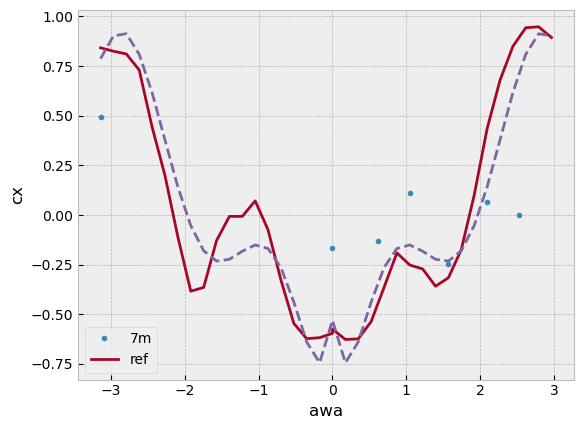

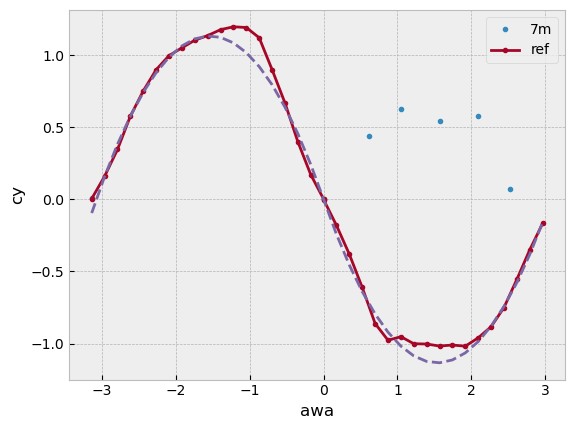

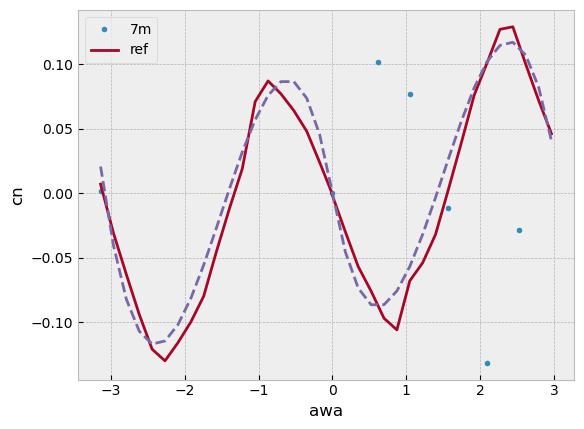

In [65]:
fig,ax=plt.subplots()
wind_data.plot(x='awa', y='cx', label='7m', style='.', ax=ax)
wind_data_HMD.plot(x='awa', y='cx', label='ref', ax=ax)

x = data_['awa'].values
y = data_['cx']
deg_x = 6
X = get_X_abs(x=x, deg=deg_x)
coeffs_cx,_,_,_ = np.linalg.lstsq(X.transpose(),y)
ax.plot(data_['awa'],coeffs_cx.dot(X).flatten(),'--', label='polynom')
ax.set_ylabel('cx')

fig,ax=plt.subplots()
wind_data.plot(x='awa', y='cy', label='7m', style='.', ax=ax)
wind_data_HMD.plot(x='awa', y='cy', style='.-',label='ref', ax=ax)
y = data_['cy']
deg_y = 2
X = get_X_sign(x=x, deg=deg_y, const=False)
coeffs_cy,_,_,_ = np.linalg.lstsq(X.transpose(),y)
ax.plot(data_['awa'],coeffs_cy.dot(X).flatten(),'--', label='polynom')
ax.set_ylabel('cy')

fig,ax=plt.subplots()
wind_data.plot(x='awa', y='cn', label='7m', style='.', ax=ax)
wind_data_HMD.plot(x='awa', y='cn', label='ref', ax=ax)
y = data_['cn'].copy()
mask = data_['awa'] < 0
y.loc[mask]*=-1
deg_n = 3
X = get_X_sign(x=x, deg=deg_n, const=False)
coeffs_cn,_,_,_ = np.linalg.lstsq(X.transpose(),y)
ax.plot(data_['awa'],coeffs_cn.dot(X).flatten(),'--', label='polynom')
ax.set_ylabel('cn')

In [66]:
def eq_abs(deg=1, symbol_prefix="C_x", const=True):
    
    if const:
        stop = -1
    else:
        stop = 0
    
    coefficient_symbols = get_coefficient_symbols(deg=deg, symbol_prefix=symbol_prefix, const=const)
    
    awa = sp.symbols('awa', real=True)
    return reduce(add,[sp.symbols(f"{symbol}")*sp.Abs(awa**i) for i,symbol in zip(range(deg,stop,-1), coefficient_symbols)])

def eq_sign(deg=1, symbol_prefix="C_x", const=True):
    
    if const:
        stop = -1
    else:
        stop = 0
        
    awa = sp.symbols('awa', real=True)
    
    coefficient_symbols = get_coefficient_symbols(deg=deg, symbol_prefix=symbol_prefix, const=const)
        
    return reduce(add,[sp.symbols(f"{symbol}")*awa*sp.Abs(awa**(i-1)) if np.mod(i,2)==0 else sp.symbols(f"{symbol}")*awa**i for i,symbol in zip(range(deg,stop,-1), coefficient_symbols)])


def get_coefficient_symbols(deg=1, symbol_prefix="C_x", const=True):
    
    if const:
        stop = -1
    else:
        stop = 0
        
    return [sp.symbols(f"{symbol_prefix}{i}") for i in range(deg,stop,-1)]
    


In [67]:
eq_abs(deg=deg_x)

C_x0 + C_x1*Abs(awa) + C_x2*awa**2 + C_x3*awa**2*Abs(awa) + C_x4*awa**4 + C_x5*awa**4*Abs(awa) + C_x6*awa**6

In [68]:
expression = eq_sign(deg=deg_y, const=False)
expression

C_x1*awa + C_x2*awa*Abs(awa)

In [69]:
awa = sp.symbols('awa', real=True)
expression.diff(awa)

C_x1 + C_x2*awa*sign(awa) + C_x2*Abs(awa)

In [70]:
aws, A_XV, A_YV, rho_A, F_Wx, F_Wy, M_Wz = sp.symbols('aws, A_XV, A_YV, rho_A, F_Wx, F_Wy, M_Wz', real=True)

C_xs = eq_abs(deg=deg_x, symbol_prefix='C_x')
#eq_F_Wx = sp.Eq(F_Wx, sp.Rational(1,2)*rho_A*A_XV*aws**2*C_xs)
eq_F_Wx = sp.expand(sp.Eq(F_Wx, rho_A*A_XV*aws**2*C_xs))  # 1/2 is stored in the C_x...

C_ys = eq_sign(deg=deg_y, symbol_prefix='C_y', const=False)
eq_F_Wy = sp.expand(sp.Eq(F_Wy, rho_A*A_YV*aws**2*C_ys))

C_ns = eq_sign(deg=deg_n, symbol_prefix='C_n', const=False)
eq_M_Wz = sp.expand(sp.Eq(M_Wz, rho_A*A_YV*aws**2*C_ns*L))


display(eq_F_Wx)
display(eq_F_Wy)
display(eq_M_Wz)


Eq(F_Wx, A_XV*C_x0*aws**2*rho_A + A_XV*C_x1*aws**2*rho_A*Abs(awa) + A_XV*C_x2*awa**2*aws**2*rho_A + A_XV*C_x3*awa**2*aws**2*rho_A*Abs(awa) + A_XV*C_x4*awa**4*aws**2*rho_A + A_XV*C_x5*awa**4*aws**2*rho_A*Abs(awa) + A_XV*C_x6*awa**6*aws**2*rho_A)

Eq(F_Wy, A_YV*C_y1*awa*aws**2*rho_A + A_YV*C_y2*awa*aws**2*rho_A*Abs(awa))

Eq(M_Wz, A_YV*C_n1*L*awa*aws**2*rho_A + A_YV*C_n2*L*awa*aws**2*rho_A*Abs(awa) + A_YV*C_n3*L*awa**3*aws**2*rho_A)

In [71]:
coeffs_cx_dict = {str(symbol):value/2 for symbol,value in zip(get_coefficient_symbols(deg=deg_x, symbol_prefix="C_x", const=True), coeffs_cx)}
coeffs_cy_dict = {str(symbol):value/2 for symbol,value in zip(get_coefficient_symbols(deg=deg_y, symbol_prefix="C_y", const=False), coeffs_cy)}
coeffs_cn_dict = {str(symbol):value/2 for symbol,value in zip(get_coefficient_symbols(deg=deg_n, symbol_prefix="C_n", const=False), coeffs_cn)}

In [72]:
lambda_F_Wx = lambdify(eq_F_Wx.rhs)
lambda_F_Wy = lambdify(eq_F_Wy.rhs)
lambda_M_Wz = lambdify(eq_M_Wz.rhs)

In [73]:
print(inspect.getsource(lambda_F_Wx))

def _lambdifygenerated(A_XV, C_x0, C_x1, C_x2, C_x3, C_x4, C_x5, C_x6, awa, aws, rho_A):
    return A_XV*C_x0*aws**2*rho_A + A_XV*C_x1*aws**2*rho_A*abs(awa) + A_XV*C_x2*awa**2*aws**2*rho_A + A_XV*C_x3*awa**2*aws**2*rho_A*abs(awa) + A_XV*C_x4*awa**4*aws**2*rho_A + A_XV*C_x5*awa**4*aws**2*rho_A*abs(awa) + A_XV*C_x6*awa**6*aws**2*rho_A



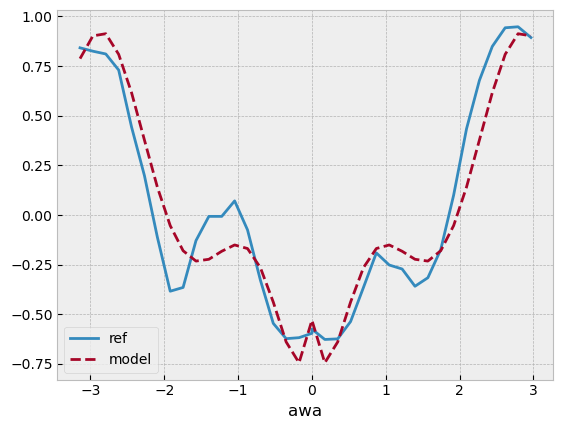

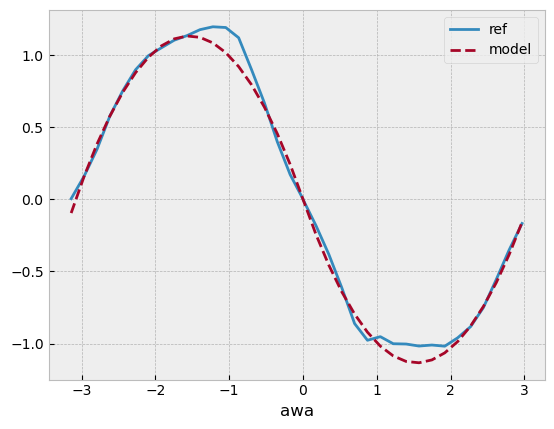

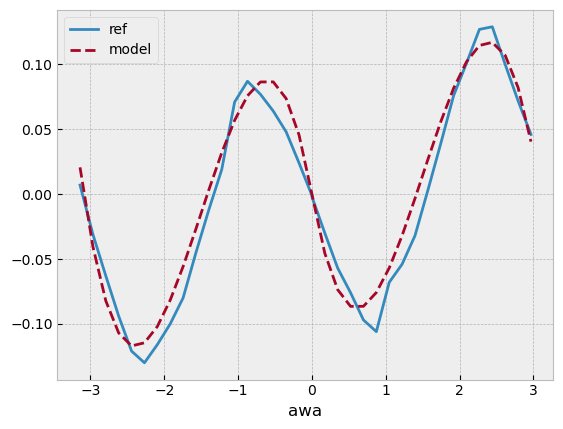

In [74]:
fig,ax=plt.subplots()
wind_data_HMD.plot(x='awa', y='cx', label='ref', ax=ax)
x = wind_data_HMD['awa']
y = 2*run(lambda_F_Wx, inputs=wind_data_HMD, **coeffs_cx_dict, aws=1, rho_A=1, A_XV=1)
ax.plot(x,y,'--', label='model')
ax.legend()


fig,ax=plt.subplots()
wind_data_HMD.plot(x='awa', y='cy', label='ref', ax=ax)
x = wind_data_HMD['awa']
y = 2*run(lambda_F_Wy, inputs=wind_data_HMD, **coeffs_cy_dict, aws=1, rho_A=1, A_YV=1)
ax.plot(x,y,'--', label='model')
ax.legend()

fig,ax=plt.subplots()
wind_data_HMD.plot(x='awa', y='cn', label='ref', ax=ax)
x = wind_data_HMD['awa']
y = 2*run(lambda_M_Wz, inputs=wind_data_HMD, **coeffs_cn_dict, aws=1, rho_A=1, A_YV=1, L=1)
ax.plot(x,y,'--', label='model')
ax.legend()


In [75]:
df_prime.loc['denominator','force']

L**2*U**2*rho/2

In [76]:
vmm.Y_eq

Eq(m*(\dot{r}*x_G + \dot{v} + r*u), Y_{\dot{r}}*\dot{r} + Y_{\dot{v}}*\dot{v} + Y_{delta}*delta + Y_{v}*v)

In [77]:
sp.sign(-10)

-1

In [78]:
eq_F_Wx_ = sp.expand(eq_F_Wx.subs([
    (awa, eq_awa.rhs,),
    (aws, eq_aws.rhs,),
    ]))

eq_F_Wy_ = sp.expand(eq_F_Wy.subs([
    (awa, eq_awa.rhs,),
    (aws, eq_aws.rhs,),
    ]))

eq_M_Wz_ = sp.expand(eq_M_Wz.subs([
    (awa, eq_awa.rhs,),
    (aws, eq_aws.rhs,),
    ]))

In [79]:
X_eq = sp.Eq(vmm.X_eq.lhs, vmm.X_eq.rhs + eq_F_Wx.rhs)
Y_eq = sp.Eq(vmm.Y_eq.lhs, vmm.Y_eq.rhs + eq_F_Wy.rhs)
N_eq = sp.Eq(vmm.N_eq.lhs, vmm.N_eq.rhs + eq_M_Wz.rhs)

#X_eq = sp.Eq(vmm.X_eq.lhs, vmm.X_eq.rhs + eq_F_Wx_.rhs)
#Y_eq = sp.Eq(vmm.Y_eq.lhs, vmm.Y_eq.rhs + eq_F_Wy_.rhs)
#N_eq = sp.Eq(vmm.N_eq.lhs, vmm.N_eq.rhs + eq_M_Wz_.rhs)


In [80]:
X_eq

Eq(m*(\dot{u} - r**2*x_G - r*v), A_XV*C_x0*aws**2*rho_A + A_XV*C_x1*aws**2*rho_A*Abs(awa) + A_XV*C_x2*awa**2*aws**2*rho_A + A_XV*C_x3*awa**2*aws**2*rho_A*Abs(awa) + A_XV*C_x4*awa**4*aws**2*rho_A + A_XV*C_x5*awa**4*aws**2*rho_A*Abs(awa) + A_XV*C_x6*awa**6*aws**2*rho_A + X_{\dot{u}}*\dot{u} + X_{deltadelta}*delta**2 + X_{u}*u + X_{vr}*r*v + X_{vv}*v**2)

In [81]:
vmm2 = VMM(X_eq=X_eq, Y_eq=Y_eq, N_eq=N_eq)

In [82]:
model = model_loaders["vmm_abkowitz_diminished"]()

In [83]:
simulator = Simulator(X_eq=vmm2.X_eq, Y_eq=vmm2.Y_eq, N_eq=vmm2.N_eq)
simulator.define_quasi_static_forces(X_qs_eq=vmm2.X_qs_eq, Y_qs_eq=vmm2.Y_qs_eq, N_qs_eq=vmm2.N_qs_eq)

In [84]:
ship_data

{'T': 0.284,
 'L': 7.0,
 'B': 1.3,
 'rho': 1025,
 'x_G': -0.3266666666666667,
 'm': 1155,
 'I_z': 3386.0314842592607,
 'volume': 1.063551724137931,
 'CB': 0.41152752056103203,
 'x_r': -3.3168459992407717,
 'scale_factor': 30,
 'TWIN': 1,
 'D': 0.17,
 'A_XV': 1.12,
 'A_YV': 6.037,
 'rho_A': 1.225}

In [85]:
parameters = pd.concat((model.parameters, pd.Series(coeffs_cx_dict), pd.Series(coeffs_cy_dict), pd.Series(coeffs_cn_dict)))
ship_data_ = ship_data.copy()
#ship_data_['I_z']*=0.7
#parameters['Xuu']*=1.01
parameters['Xu']*=1.01
model2 = ModelSimulator(simulator=simulator, parameters=parameters, ship_parameters=ship_data_, control_keys=['delta','twa','tws'], prime_system=model.prime_system)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:6                                                                                    │
│                                                                                                  │
│   3 #ship_data_['I_z']*=0.7                                                                      │
│   4 #parameters['Xuu']*=1.01                                                                     │
│   5 parameters['Xu']*=1.01                                                                       │
│ ❱ 6 model2 = ModelSimulator(simulator=simulator, parameters=parameters, ship_parameters=ship     │
│   7                                                                                              │
│                                                                                                  │
│ /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/models/vmm.py:613 in __init__    │
│                                                                                                  │
│    610 │   │   """                                                                               │
│    611 │   │                                                                                     │
│    612 │   │   self.__dict__.update(simulator.__dict__)                                          │
│ ❱  613 │   │   self.parameters = self.extract_needed_parameters(parameters)                      │
│    614 │   │   self.ship_parameters = ship_parameters                                            │
│    615 │   │   self.control_keys = control_keys                                                  │
│    616 │   │   self.primed_parameters = primed_parameters                                        │
│                                                                                                  │
│ /home/maa/dev/VesselManoeuvringModels/vessel_manoeuvring_models/models/vmm.py:632 in             │
│ extract_needed_parameters                                                                        │
│                                                                                                  │
│    629 │   │                                                                                     │
│    630 │   │   missing_coefficients = set(coefficients) - set(parameters.keys())                 │
│    631 │   │   assert (                                                                          │
│ ❱  632 │   │   │   len(missing_coefficients) == 0                                                │
│    633 │   │   ), f"Missing parameters:{missing_coefficients}"                                   │
│    634 │   │                                                                                     │
│    635 │   │   return parameters[coefficients]                                                   │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AssertionError: Missing parameters:{'Nvvv'}

In [ ]:
try:
    model_loaders_7m = catalog.load(f"7m.models")
except Exception:
    model_loaders_7m = {}
    
model_loaders_7m["vmm_abkowitz_diminished_wind"] = model2

catalog.save(f"7m.models", model_loaders_7m)

In [ ]:
result = model.simulate(data)

In [ ]:
data_ = data.copy()
data_['awa'] = smallest_signed_angle(data['awa'])
#data_['delta']+=np.deg2rad(3.5)
#data_['psi']-=np.deg2rad(10)
#data_['aws']*=1.25
result2 = model2.simulate(data_)

In [ ]:
np.rad2deg(mean_angle(data['twa']))

In [ ]:
df_result_wind = result2.result.copy()
dataframes = {
'Experiment':mean(data.rolling(2)),
#'Experiment':data,
'model' : result.result,
'model2' : df_result_wind
    
}
time_window=[0, np.inf]
ax = track_plots(dataframes=dataframes, lpp=ship_data['L'], beam=ship_data['B'], 
             time_window=time_window, N=10);
ax.legend(loc='upper right')

plot(dataframes, keys=['u','v','r','psi','aws','awa','cog'], time_window=time_window);

In [ ]:
df_result_wind['awa'] = smallest_signed_angle(df_result_wind['awa'])

df_result_wind['F_Wx'] = run(lambda_F_Wx, inputs=df_result_wind, **ship_data, **model2.parameters)
df_result_wind['F_Wy'] = run(lambda_F_Wy, inputs=df_result_wind, **ship_data, **model2.parameters)
df_result_wind['M_Wz'] = run(lambda_M_Wz, inputs=df_result_wind, **ship_data, **model2.parameters)

df_result_wind['Cy'] = df_result_wind['F_Wy']/(1/2*df_result_wind['aws']**2*ship_data['rho_A']*ship_data['A_YV']) 
df_result_wind['Cn'] = df_result_wind['M_Wz']/(1/2*df_result_wind['aws']**2*ship_data['rho_A']*ship_data['A_YV']*ship_data['L']) 

fig,axes=plt.subplots(nrows=4)
df_result_wind.plot(y='awa', style='k', ax=axes[0])
df_result_wind.plot(y='F_Wx', style='r', ax=axes[1])
df_result_wind.plot(y='F_Wy', style='g', ax=axes[2])
df_result_wind.plot(y='M_Wz', style='b', ax=axes[3])

data_.plot(y='awa')

In [ ]:
fig,ax=plt.subplots()
data.plot(y=['awsBowRAW','awsSternRAW'], alpha=0.25, ax=ax)
ax.plot(data.index, data[['awsBowRAW','awsSternRAW']].mean(axis=1), label='mean')
ax.legend()

In [ ]:
fig,ax=plt.subplots()
data.plot(y=['awaBowRAW','awaSternRAW'], alpha=0.25, ax=ax)
#ax.plot(data.index, data[['awaBowRAW','awaSternRAW']].mean(axis=1), label='mean')
ax.plot(data.index, np.unwrap(mean_angle(data[['awaBowRAW','awaSternRAW']], axis=1)), label='mean')
ax.legend()

In [ ]:
fig,ax=plt.subplots()
ax.plot(data['awsBowRAW'] - data['awsSternRAW'])
ax2 = ax.twinx()
ax2.plot(data['psi'], 'r-')